### eecs545 homework 2
Author: Zijin Zhang  
UMID: 40703833

### Question 2 -- Naive Bayes for Spam Filtering

In [218]:
import numpy as np
z = np.genfromtxt('spambase.data', dtype=float, delimiter=',')
np.random.seed(0)  # Seed the random number generator
rp = np.random.permutation(z.shape[0])  # random permutation of indices
z = z[rp, :]  # shuffle the rows of z
x = z[:, :-1]
y = z[:, -1]

In [219]:
# data processing
x_T = x.T
x_train = x_T[:, :2000]
x_test = x_T[:, 2000:]
y_train = y[:2000]
y_test = y[2000:]

# quantize the variable to simplify calculation
def quantize(x):
    x_quant = x.copy()
    for i in range(len(x)):
        col_median = np.median(x[i])
        for j in range(len(x[0])):
            if x[i][j] <= col_median:
                x_quant[i][j] = 1
            else:
                x_quant[i][j] = 2
    return x_quant

x_quant_train = quantize(x_train)
x_quant_test = quantize(x_test)

In [220]:
def naive_bayes_classifiers(features, label, input_data):
    label_prob = {}
    label_space = list(set(label))
    len_label = len(label_space)
    len_features = len(features)
    
    # get the prior probability of different labels
    for i in range(len_label):
        label_prob[label_space[i]] = len(label[label == label_space[i]]) / len(label)

    # get feature space, due to quantizing, this only includes 1 and 2
    features_space = {}
    for i in range(len_features):
        features_space[i] = list(set(features[i]))

    # get the probability of label given features
    prb_feature_label = {}
    for i in range(len_features):
        for j in range(len(features_space[i])):  # here is should just be 2 (1 and 2)
            for k in range(len_label):
                label_select = label[label == label_space[k]]
                label_index = np.where(label == label_space[k])
                feature_obj = np.array(features[i])[label_index]
                numerator = feature_obj[feature_obj == features_space[i][j]]
                key_word = str(i) + str(features_space[i][j]) + str(label_space[k])
                prb_feature_label[key_word] = len(numerator) / len(label_select)

    # This is used to calculate the probabality of different labels givent feature info
    prob_space = {}
    temp = 1
    for i in range(len_label):
        prob_space[label_space[i]] = label_prob[label_space[i]]
        for j in range(len(input_data)):
            key_word = str(j) + str(input_data[j]) + str(label_space[i])
            temp *= prb_feature_label[key_word]
        prob_space[label_space[i]] = prob_space[label_space[i]] * temp
        temp = 1

    # return the label that has higher Probability
    return max(prob_space, key = prob_space.get)

In [221]:
# sanity test error check 
features = x_quant_train
label = y_train
error = 0
for i in range(len(x_quant_test.T)):
    input_data = x_quant_test.T[i]
    output_label = naive_bayes_classifiers(features, label, input_data)
    if output_label != y_test[i]:
        error += 1

error_rate = error / len(x_quant_test.T)
error_rate

0.10649750096116878

In [223]:
print('The test error rate is approximately', error_rate)

The test error rate is approximately 0.10649750096116878


### Question 4 -- Logistic Regression

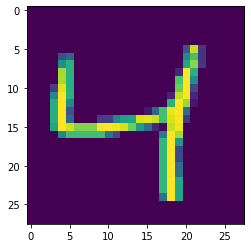

(784, 3000)
(1, 3000)


In [224]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

mnist_49_3000 = sio.loadmat('mnist_49_3000.mat')
x = mnist_49_3000['x']
y = mnist_49_3000['y']
d, n = x.shape

i = 0  # Index of the image to be visualized
plt.imshow(np.reshape(x[:, i], (int(np.sqrt(d)), int(np.sqrt(d)))))
plt.show()

print(x.shape)
print(y.shape)

# process x, y so that they could be easily used later
x = np.concatenate((np.array([1]*len(x[0])).reshape((1,-1)), np.array(x)), axis= 0)
y = y[0]

In [227]:
def sigmoid(t):
    return np.log(1 + np.exp(-t))

In [228]:
def objective(x, y, theta, Lambda):
    # Objective function
    sum_term = 0
    for i in range(len(x[0])):
        sum_term += sigmoid(y[i] * theta.dot(x[:,i]))
    return sum_term + Lambda * theta.dot(theta)

In [229]:
def gradient(x, y, theta, Lambda): 
    # gradient of theta
    n = len(x[0])
    sum_term = np.sum([- y[i] * x[:,i] / (1 + np.exp(y[i] * theta.dot(x[:, i]))) for i in range(n)], axis = 0)
    return sum_term + 2 * Lambda * theta

In [233]:
def hessian(x, y, theta, Lambda):
    # hessian of theta
    sum_term = np.sum([(np.exp(- y[i] * theta.dot(x[:,i])) / (1 + np.exp(- y[i] * theta.dot(x[:,i])))**2) * x[:,i].reshape((-1, 1)).dot(x[:, i].reshape((1, -1))) * y[i]**2 for i in range(len(x[0]))], axis = 0)
    return sum_term + 2 * Lambda * np.eye((len(x)))

In [236]:
# train-test split
x_train = x[:,:2000]
x_test =  x[:,2000:]
y_train = y[:2000]
y_test = y[2000:]

In [237]:
def newton(theta, x, y, Lambda, epsilon):
    obj_curr = objective(x, y, theta, Lambda)
    iterations = 0
    accuracy = float('inf')
    while accuracy > epsilon:
        theta = theta - np.matmul(np.linalg.inv(hessian(x, y, theta, Lambda)), gradient(x, y, theta, Lambda))
        iterations += 1
        obj_next = objective(x, y, theta, Lambda)
        print('Iteration:', iterations, ', Loss:', obj_next)
        accuracy = np.abs(obj_curr - obj_next) / obj_curr
        obj_curr = obj_next
    print("==========================================")
    print('Total number of iterations is', iterations, ', loss is', obj_curr)
    return iterations, obj_curr, theta

theta = np.array([0] * len(x_train))
Lambda = 10
epsilon = 1e-6
iterations, obj_curr, theta = newton(theta, x_train, y_train, Lambda, epsilon)

# predict test set
predict = 1 / (1 + np.exp(- theta.dot(x_test)))
predict[np.where(predict >= 0.5)] = 1
predict[np.where(predict < 0.5)] = -1

error_rate = np.mean(predict != y_test)
print('After', iterations, 'iterations, error rate', error_rate)

Iteration: 1 , Loss: 485.05568605001065
Iteration: 2 , Loss: 343.20225081950514
Iteration: 3 , Loss: 310.5342113909063
Iteration: 4 , Loss: 307.6847385748812
Iteration: 5 , Loss: 307.6554674747582
Iteration: 6 , Loss: 307.65546352880267
Total number of iterations is 6 , loss is 307.65546352880267
After 6 iterations, error rate 0.048


In [243]:
# get the position of wrong predict
predict_wrong = np.where(predict != y_test)[0]
predict_wrong = predict[np.where(predict != y_test)[0]]
predict_wrong = np.argsort(np.abs(predict_wrong) - 0.5)
predict_wrong

array([ 0, 26, 27, 28, 29, 30, 31, 32, 33, 34, 25, 35, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 36, 24, 23, 22,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 46, 47])

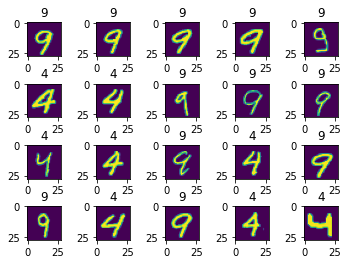

In [245]:
for i in range(1, 21): 
    ax = plt.subplot(4,5,i)
    position = predict_wrong[predict_wrong[-i]] 
    title = 0
    if y_test[position] == 1:
        title = 9 
    else:
        title = 4
    plt.title(title)
    plt.subplots_adjust(hspace=0.8)
    ax.imshow(np.reshape(x_test[1:, position], (28,28)))

__Remark:__  
In this case, I applied the degree of confidence abs(predict - 0.5) since it is closer to our intuition in terms of probability, which is between 0 and 1. When it is closer to 1 or 0, they will probably show good performance, while it may have trouble deciding which way to go when it is near 0.5.